$
\huge{
\textbf{
BaSTI Isochrones Only Notebook
}
}
$

In [2]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, vstack, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16}) #make plots more readable

import MagellanicStream as ms
import astropy.units as u
from astropy.coordinates import SkyCoord
from uncertainties import ufloat

import warnings
warnings.filterwarnings('ignore')

import glob

In [3]:
##############################
### User defined functions ###
##############################

def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

import pandas as pd #needed for readbasti
def readbasti(file):
    with open(file) as f:
        lines = f.readlines()
        met_age = lines[4].split(' ')
        met = float(met_age[9]) #9th element after line[4] split
        age = float(met_age[-1]) #last element after line[4] split
        df = pd.read_csv(file,comment='#',names=['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG'],sep='\s+')
        table_out = Table.from_pandas(df)
        metcol = Column(np.ones(len(table_out))*met, name='FEH')
        table_out.add_column(metcol)
        agecol = Column(np.log10(np.ones(len(table_out))*(age*10**6)), name='LOGAGE')
        table_out.add_column(agecol)
        mas = df['MFIN']*(1.99*10**33) #mass in g
        tem = 10**df['LOGT'] #T in K
        lum = (10**df['LOGL'])*(3.9*10**33) #L in erg/s
        lggcol = Column(np.log10((6.67259*10**-8)*(mas)*4*np.pi*(5.67051*10**-5)*(tem**4)/(lum)),name='LOGG')
        table_out.add_column(lggcol)
    return table_out

def mad(dat):
    return np.median(np.absolute(dat - np.median(dat)))

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [4]:
#create .dat files for the BaSTI isochrones along with monarch and astropy table
files = glob.glob('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/*.isc_2mass')

nom = ['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG','FEH','LOGAGE','LOGG']

noperiod = []
for i in range(len(files)):
    #new_files.append('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/'+files[i])
    splt = files[i].split('.')
    noperiod.append(splt[0]+splt[1])

for j in range(len(files)):
    tab = readbasti(files[j])
    tab.write('{}.dat'.format(noperiod[j]),format='csv',overwrite=True)
    
datfiles = glob.glob('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/*.dat')
output_file = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_monarch.dat'
for i, fname in enumerate(datfiles):
    df = pd.read_csv(fname)
    if i==0:
        df.to_csv(output_file, index = False)
    else:
        df.to_csv(output_file, mode = 'a+', index = False, header = False)
        
#create rgb only table
#rgb branch 489 to 1289 in each isochrone

out_rgb  = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_rgb.dat'
for i, fname in enumerate(datfiles):
    df2 = pd.read_csv(fname,names=nom)
    df2 = df2[489:1289]
    df2.to_csv(out_rgb, mode = 'a+', index= False, header = False)

In [5]:
#Read in All dat file
basti = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_monarch.dat')
tbasti = Table.from_pandas(basti)

#Read in RGB dat file
nom = ['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG','FEH','LOGAGE','LOGG']
rgbdat = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_rgb.dat',names=nom)
trgb = Table.from_pandas(rgbdat)
tempcut = np.where(trgb['LOGT']<=3.75)
trgb = trgb[tempcut]

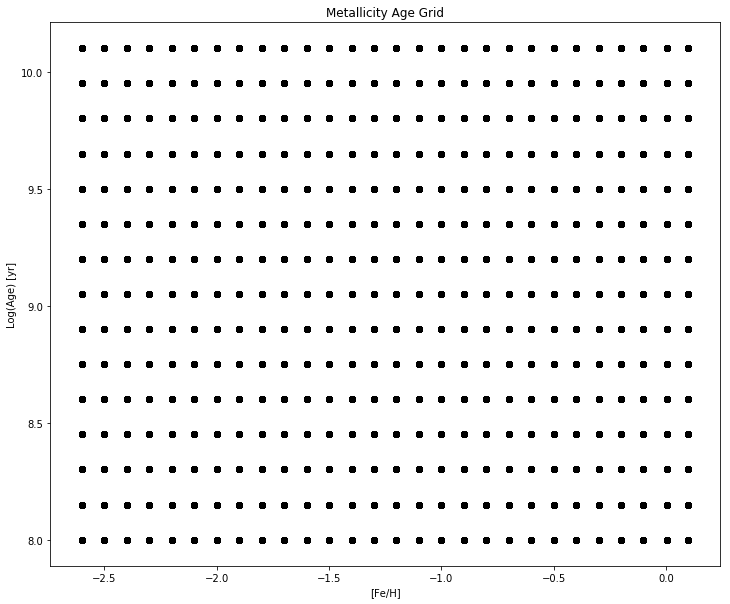

In [6]:
#Metallicity Age
plt.figure(figsize=[12,10])
plt.scatter(basti['FEH'],basti['LOGAGE'],c='k')
plt.ylabel(r'Log(Age) [yr]')
plt.xlabel(r'[Fe/H]')
plt.title(r'Metallicity Age Grid')
plt.savefig('BaSTIgrid.pdf',bbox_inches='tight')
plt.show()

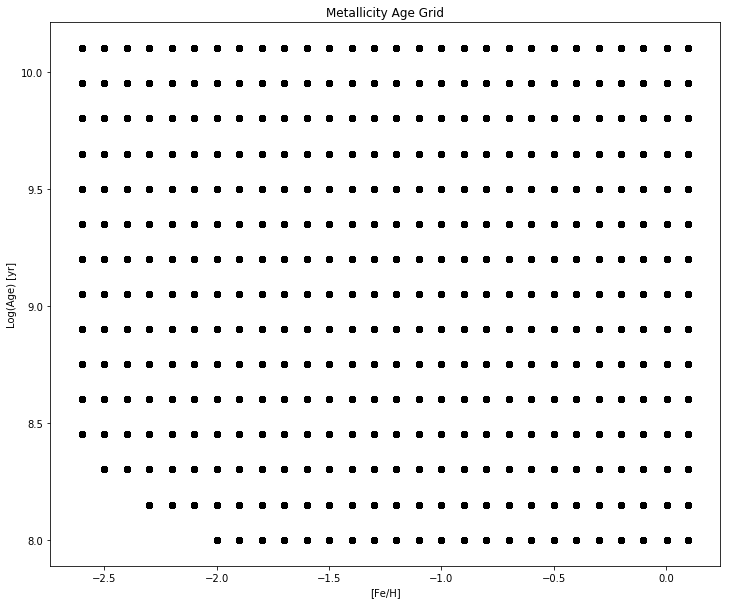

In [7]:
#Metallicity Age
plt.figure(figsize=[12,10])
plt.scatter(trgb['FEH'],trgb['LOGAGE'],c='k')
plt.ylabel(r'Log(Age) [yr]')
plt.xlabel(r'[Fe/H]')
plt.title(r'Metallicity Age Grid')
plt.savefig('BaSTIrgbgrid.pdf',bbox_inches='tight')
plt.show()

In [8]:
##########################
### Log(g) Calculation ###
##########################

'''Inserted into readbasti function'''

# mas = tbasti['MFIN']*(1.99*10**33) #mass in g
# tem = 10**tbasti['LOGT'] #T in K
# lum = (10**tbasti['LOGL'])*(3.9*10**33) #L in erg/s

# logg = np.log10((6.67259*10**-8)*(mas)*4*np.pi*(5.67051*10**-5)*(tem**4)/(lum))

'Inserted into readbasti function'

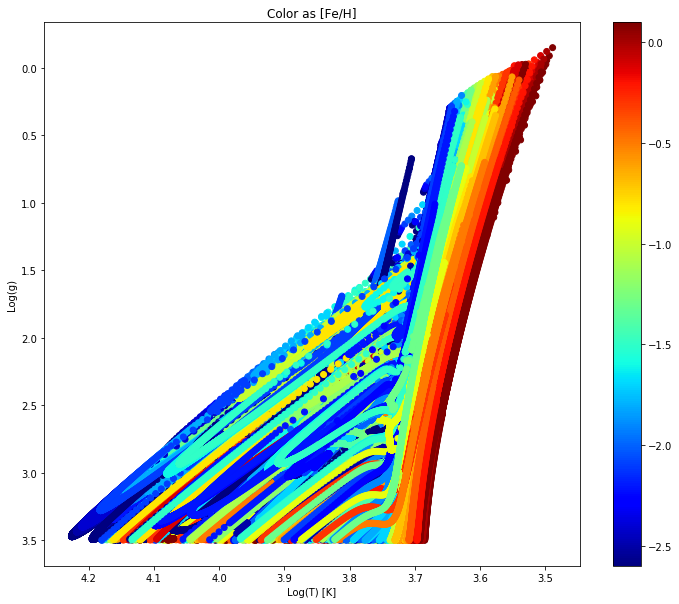

In [9]:
rgb = np.where(tbasti['LOGG']<3.5)

plt.figure(figsize=[12,10])
plt.scatter(tbasti['LOGT'][rgb],tbasti['LOGG'][rgb],c=tbasti['FEH'][rgb],cmap='jet')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'Log(T) [K]')
plt.ylabel(r'Log(g)')
plt.title(r'Color as [Fe/H]')
plt.show()

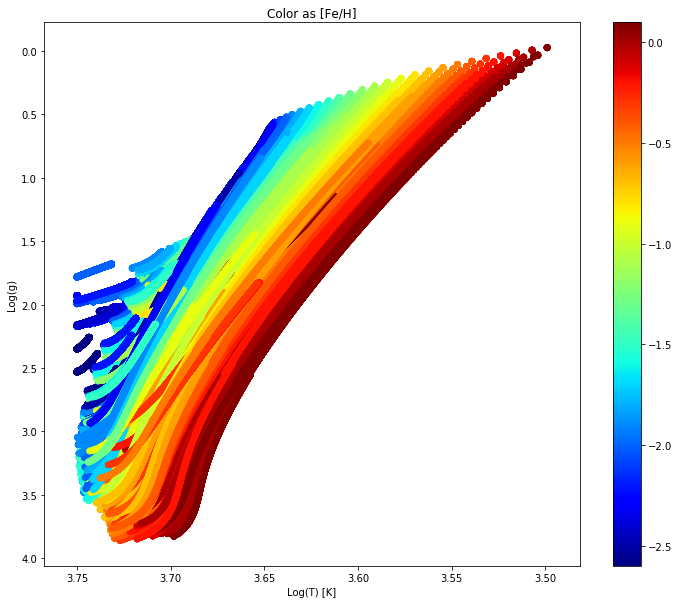

In [10]:
plt.figure(figsize=[12,10])
plt.scatter(trgb['LOGT'],trgb['LOGG'],c=trgb['FEH'],cmap='jet')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'Log(T) [K]')
plt.ylabel(r'Log(g)')
plt.title(r'Color as [Fe/H]')
plt.show()

In [11]:
# set(tbasti[rgb]['LOGAGE'])
# #set(tbasti[rgb]['FEH'])
# #4.10-3.32

In [12]:
rgbage = np.where((tbasti['FEH']==0.099)&(tbasti['LOGAGE']==8.0))

# #TRGB idx = 1289

# idx= 489

# Imag = 4.10-2.5*np.copy(tbasti['LOGL']) #4.10 is the I for the sun
# # mag[rgbage]

# plt.figure(figsize=[12,10])
# plt.scatter(tbasti['LOGT'][rgbage],Imag[rgbage],c=tbasti['MFIN'][rgbage]*(1.99*10**33),cmap='jet',marker='+')
# plt.scatter(tbasti[rgbage]['LOGT'][idx],Imag[rgbage][idx],marker='+',c='slategrey',s=500)
# plt.xlim(3.65,3.75)
# plt.ylim(-4.5,-2.75)
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
# #plt.colorbar()
# plt.xlabel(r'Log(T) [K]')
# plt.ylabel(r'I')
# #plt.title(r'Color as [Fe/H]')
# plt.show()

(array([476]),)


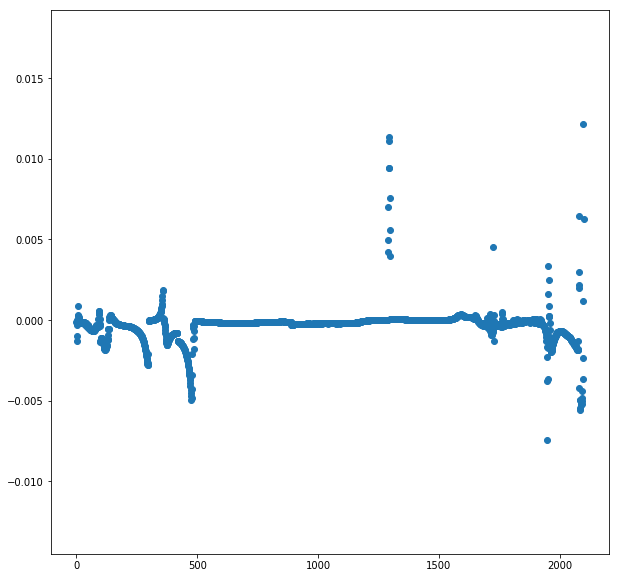

In [13]:
def der(x,y):
    ders = []
    for i in range(len(x)-1):
        ders.append((y[i+1]-y[i])/(x[i+1]+x[i]))
    return np.asarray(ders)

print(np.where(der(tbasti[rgbage]['LOGT'],tbasti[rgbage]['LOGG'])==der(tbasti[rgbage]['LOGT'],tbasti[rgbage]['LOGG'])[400:600].min()))

# def jump(x,y):
#     jumps = []
#     for i in range(len(x)-1):
#         jumps.append(np.sqrt((x[i+1]-x[i])**2+(y[i+1]-y[i])**2))
#     return jumps

plt.figure(figsize=[10,10])
plt.scatter(range(len(tbasti[rgbage]['LOGT'])-1),der(tbasti[rgbage]['LOGT'],tbasti[rgbage]['LOGG']))
# plt.xlim(1000,2000)
# plt.ylim(-0.002,0.006)
plt.show()

# plt.figure(figsize=[10,10])
# plt.scatter(range(len(tbasti[rgbage]['LOGT'])-1),jump(tbasti[rgbage]['LOGT'],tbasti[rgbage]['LOGG']))
# plt.show()

In [14]:
##############################
### Import statsmodels.api ###
##############################

import statsmodels.api as sm 

####################
### Prepare Data ###
####################

'''parameters: logTe, Hmag, [FE/H], logg'''\

# logage = np.array(tbasti[rgb]['LOGAGE'].data)

# J = np.array(tbasti[rgb]['JMAG'].data)
# K = np.array(tbasti[rgb]['KMAG'].data)

# logteff = np.array(tbasti[rgb]['LOGT'].data)
# H = np.array(tbasti[rgb]['HMAG'].data)
# feh = np.array(tbasti[rgb]['FEH'])
# logg = np.array(tbasti[rgb]['LOGG'].data)

logage = np.array(trgb['LOGAGE'].data)

J = np.array(trgb['JMAG'].data)
K = np.array(trgb['KMAG'].data)

logteff = np.array(trgb['LOGT'].data)
H = np.array(trgb['HMAG'].data)
feh = np.array(trgb['FEH'])
logg = np.array(trgb['LOGG'].data)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.204e+08
Date:                Thu, 18 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:25:31   Log-Likelihood:             7.2321e+06
No. Observations:             2606336   AIC:                        -1.446e+07
Df Residuals:                 2606324   BIC:                        -1.446e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        432.8312      0.508    852.804      0.0

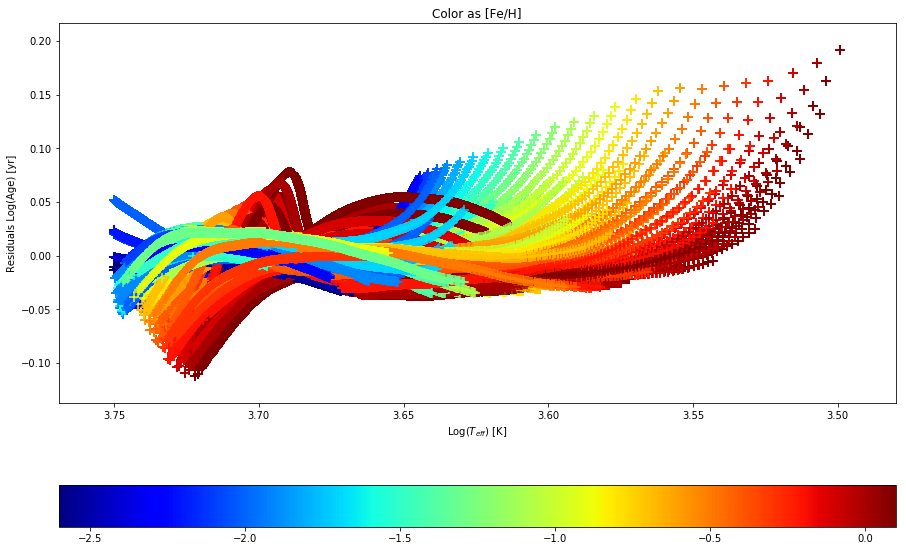

0.008429361078950315


In [15]:
#################################
### Fit PARSEC model to BaSTI ###
#################################

pmodl = np.array([logteff,K,feh,logg,np.multiply(logteff,K),np.multiply(logteff,feh),\
                   np.multiply(logteff,logg),np.multiply(K,logg),\
                   logteff**2,K**2,logg**2]).T

pmodl = sm.add_constant(pmodl)
model = sm.OLS(logage, pmodl).fit()
predictions = model.predict(pmodl) 
residual = predictions - logage
print_model = model.summary()
print(print_model)
print(model.params)

plt.figure(figsize=[15,10])
plt.scatter(logteff,residual,c=feh,marker='+',s=100,cmap='jet')
plt.colorbar(orientation='horizontal')
plt.gca().invert_xaxis()
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Log($T_{eff})$ [K]')
plt.ylabel(r'Residuals Log(Age) [yr]')
# plt.savefig('BaSTIresiduals.pdf',bbox_inches='tight')
plt.show()

print(mad(residual))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.417e+08
Date:                Thu, 18 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:26:19   Log-Likelihood:             7.5141e+06
No. Observations:             2606336   AIC:                        -1.503e+07
Df Residuals:                 2606322   BIC:                        -1.503e+07
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        989.4140      0.947   1044.475      0.0

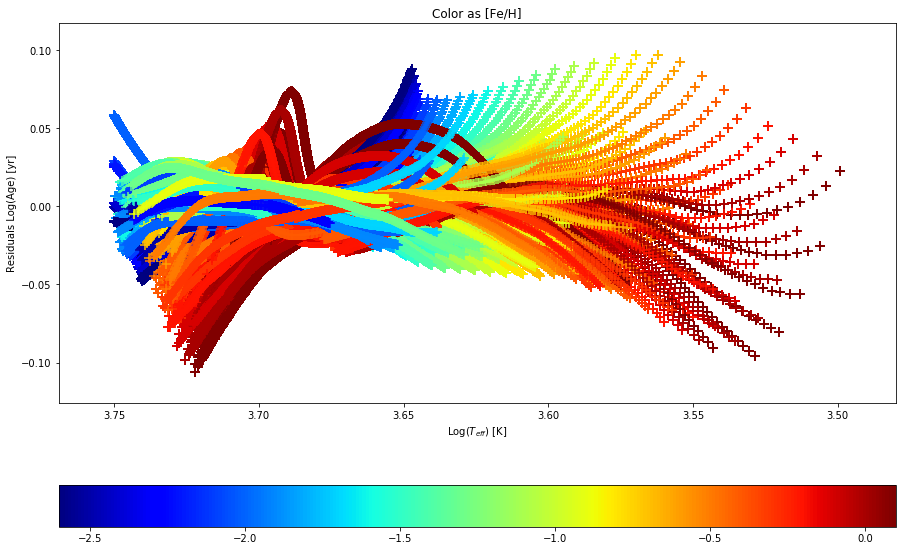

0.006948074525785053


In [16]:
###################
###  ###
###################

pmodl = np.array([logteff,K,feh,logg,np.multiply(logteff,K),np.multiply(logteff,feh),\
                  np.multiply(logteff,logg),np.multiply(K,logg),np.multiply(logteff**2,feh),\
                  np.multiply(logteff**2,K),logteff**2,K**2,logg**2]).T

pmodl = sm.add_constant(pmodl)
model = sm.OLS(logage, pmodl).fit()
predictions = model.predict(pmodl) 
residual = predictions - logage
print_model = model.summary()
print(print_model)
print(model.params)

plt.figure(figsize=[15,10])
plt.scatter(logteff,residual,c=feh,marker='+',s=100,cmap='jet')
plt.gca().invert_xaxis()
plt.colorbar(orientation='horizontal')
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Log($T_{eff})$ [K]')
plt.ylabel(r'Residuals Log(Age) [yr]')
# plt.savefig('BaSTIresiduals.pdf',bbox_inches='tight')
plt.show()

print(mad(residual))

In [17]:
'''Try something'''

#pmodl = np.array([logteff,K,feh,logg,K**2,feh**2,logteff**3]).T

#pmodl = np.array([logteff,K,feh,logg,logteff**2,K**2,feh**2,logg**2,K**3,feh**3,logg**3]).T

# pmodl = np.array([logteff,K,feh,logg,np.multiply(logteff,K),np.multiply(logteff,feh),np.multiply(logteff,logg),\
#                  np.multiply(K,logg),np.multiply(logteff**2,feh),np.multiply(logteff**2,K),logteff**2,K**2,\
#                  logg**2,logteff**3,logg**3]).T

pmodl = np.array([logteff,K,feh,logg,logteff**2,K**2,feh**2,logg**2,np.multiply(K,logg)]).T

pmodl = sm.add_constant(pmodl)
model = sm.OLS(logage, pmodl).fit()
predictions = model.predict(pmodl) 
residual = predictions - logage
print_model = model.summary()
print(print_model)
print(model.params)

# plt.figure(figsize=[15,10])
# plt.scatter(logteff,residual,c=feh,marker='+',s=100,cmap='jet')
# plt.gca().invert_xaxis()
# plt.colorbar(orientation='horizontal')
# plt.title(r'Color as [Fe/H]')
# plt.xlabel(r'Log($T_{eff})$ [K]')
# plt.ylabel(r'Residuals Log(Age) [yr]')
# # plt.savefig('BaSTIresiduals.pdf',bbox_inches='tight')
# plt.show()

print(mad(residual))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.115e+08
Date:                Thu, 18 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:27:03   Log-Likelihood:             6.5806e+06
No. Observations:             2606336   AIC:                        -1.316e+07
Df Residuals:                 2606326   BIC:                        -1.316e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -42.4481      0.166   -256.271      0.0

$\huge{\textbf{Generate and Test All Models}}$

In [18]:
import itertools as it

y1 = logteff
y2 = K
y3 = feh
y4 = logg
y12 = np.multiply(y1,y2)
y13 = np.multiply(y1,y3)
y14 = np.multiply(y1,y4)
y23 = np.multiply(y2,y3)
y24 = np.multiply(y2,y4)
y34 = np.multiply(y3,y4)
y1sq = y1**2
y2sq = y2**2
y3sq = y3**2
y4sq = y4**2

models = []
models_str = []
all_var_str = ['y1','y2','y3','y4','y12','y13','y14','y23','y24','y34','y1sq','y2sq','y3sq','y4sq']
all_var = [y1,y2,y3,y4,y12,y13,y14,y23,y24,y34,y1sq,y2sq,y3sq,y4sq]
for i in range(4, len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
    
idx = []
for j in range(len(models_str)):
    if models_str[j][0]=='y1' and models_str[j][1]=='y2' and models_str[j][2]=='y3' and models_str[j][3]=='y4':
        idx.append(j)
        
models = np.array(models)[idx]
models_str_good = np.array(models_str)[idx]

In [19]:
######################
### Fit All Models ###
######################

model_mads = []
model_params = []
model_res = []
#test = models[0:25]
for i in range(len(models)):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(logage,pmodl).fit()
    predictions = model.predict(pmodl)
    residual = predictions - logage
    model_res.append(max(np.absolute(residual)))
    model_mads.append(mad(residual))
    model_params.append(model.params)

In [20]:
best = np.where(model_mads == min(model_mads))
print(min(model_mads))
print(models_str_good[best])
np.asarray(model_params)[best]

0.006628278654948971
[array(['y1', 'y2', 'y3', 'y4', 'y12', 'y13', 'y14', 'y23', 'y24', 'y34',
       'y2sq', 'y4sq'], dtype='<U4')]


array([array([ 6.24590560e+01, -1.02980629e+01,  8.20530934e+00,  4.68358995e+00,
       -1.68242650e+01, -1.41774849e+00, -1.39823960e+00,  2.80833527e+00,
       -4.72902247e-02, -5.48881225e-01,  1.87500272e-01,  1.27975813e-01,
        5.59894274e-01])], dtype=object)

In [21]:
print(min(trgb['LOGG']))
print(max(trgb['LOGG']))

-0.02525614326027245
3.858708999978546


In [22]:
trgb.columns

<TableColumns names=('MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG','FEH','LOGAGE','LOGG')>